<a href="https://colab.research.google.com/github/Orikson/MAT-421/blob/main/MAT421_Module_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

In this notebook, we go over a few fundamental concepts of linear algebra, including linear spaces, orthogonality, eigenvalues, and linear regression. Throughout this notebook, we develop the parts we need to eventually solve the following problems:

1. Find the best fit of an $n$th order polynomial $y = \sum_{i=0}^n c_i x^i$ to some set of $2$-dimensional datapoints for various values of $n$ in a least-squared sense
2. Given a set of $3$-dimensional datapoints, find the direction of maximum extent (the largest principal component that describes the most variance in the data)

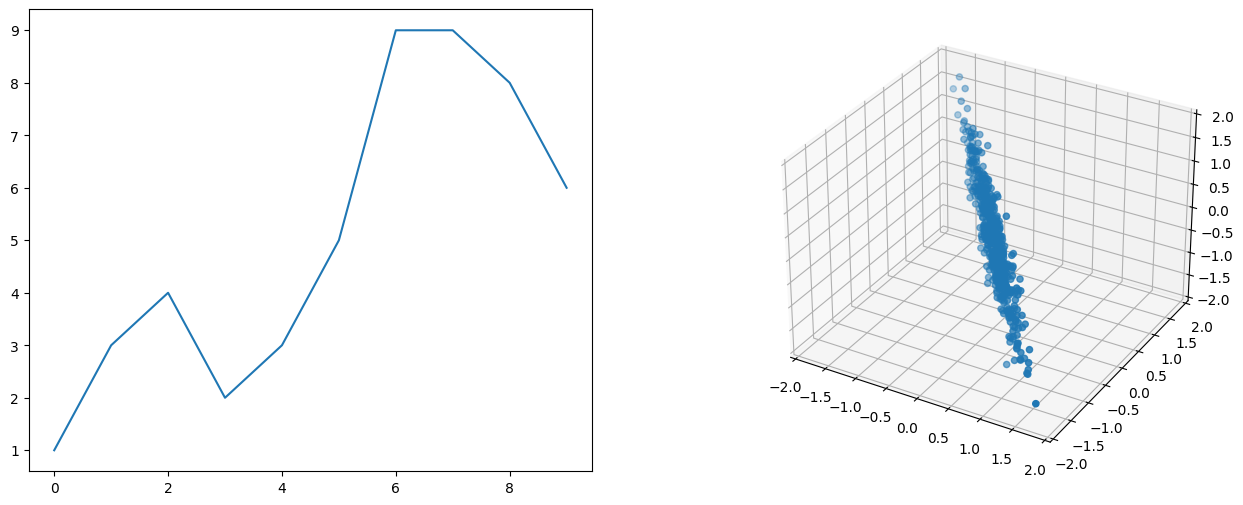

In [64]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# Plot
fig = plt.figure(figsize=(16,6))

# Problem 1
x1 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y1 = np.array([1, 3, 4, 2, 3, 5, 9, 9, 8, 6])

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x1, y1)

# Problem 2
n2 = 500
d2 = np.random.normal(size=(3, n2))

# skew data to have a known principal component
q2 = R.from_euler('xz', [45, 45], degrees=True)
d2[0] *= 0.05
d2[2] *= 0.3
d2 = np.transpose(q2.apply(np.transpose(d2)))

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(*d2)
ax2.set_xlim3d(-2, 2);
ax2.set_ylim3d(-2, 2);
ax2.set_zlim3d(-2, 2);

# Linear Space

A vector space is a set whose elements are vectors, which may be added together or multiplied by scalars. Notably, vector spaces satisfy 8 axioms. For vector addition, a vector space must satisfy associativity and commutativity, must have an identity element, and must have an inverse element. For scalar multiplication, a vector space must satisfy associativity (i.e. $a(b\mathbf{v}) = (ab)\mathbf{v}$), must have an identity element, and must satisfy distributivity with respect to vector addition and to scalar addition (i.e. $(a + b)\mathbf{v} = a\mathbf{v} + b\mathbf{v}$).

A linear subspace is a subset of a vector space that is additionally closed under vector addition and scalar multiplication. That is to say, any two vectors added together or multiplied by a scalar produces a vector also in the subspace (i.e. for linear subspace $U$ where $U \subseteq V$ and $\mathbf{a}, \mathbf{b} \in U$, then $\mathbf{a} + \mathbf{b} \in U$ and $k\mathbf{a} \in U$ for some scalar $k$).

It is notable also that any span of a set of vectors is indeed a linear subspace, where span produces the set of vectors that can be obtained by some linear combination of the input set of vectors. As such, we can construct a set of linearly independent vectors called a basis that spans any linear subspace. The code in this section demonstrates some common operations in linear subspaces given their basis vectors.

What are the basis vectors for the two proposed problems?

### Problem 1
Given data points $(\hat{x}_i, \hat{y}_i)$, we want to find a vector of coefficients $[ c_0, c_1, ..., c_n ]^\top$ such that we minimize in a least-squared sense the polynomial $c_0 x^0 + c_1 x^1 + ... + c_n x^n$. To have equal dimensions, we can construct from each $\hat{x}_i$ an n-dimensional vector $[ \hat{x}_i^0, \hat{x}_i^1, ..., \hat{x}_i^n ]^\top$. As such, the easiest basis to choose is the elementary basis of $\mathbb{R}^n$, with basis vectors $\mathbf{e}_1, \mathbf{e}_2, ... \mathbf{e}_n$. See the section on linear regression for more details on why such a representation is useful.

### Problem 2
All data points are 3-dimensional, implying that the principal component we want to identify is also 3-dimensional. As such, the easiest basis to choose is the elementary basis of $\mathbb{R}^3$, with basis vectors $\mathbf{e}_1, \mathbf{e}_2, \mathbf{e}_3$.


In [87]:
b1, b2 = np.array([1, 3, 5]), np.array([5, 3, 1])

# Linear subspaces closed under scalar multiplication and vector addition
print(f'5*b1 + b2 = {5 * b1 + b2}\n')

# [0 0 0] is not in the linear subspace spanned by b1 and b2
# We can prove this because b1 and b2 are not linearly independent
# We can show this by dividng the two basis vectors; if they were linearly independent then they would be divisible by one another to a single scalar
a = b1 / b2
print(f'b1 and b2 are linearly dependent: {np.all(a == a[0])}\n')

print(f'{3*b1 + 2*b2} = 3*b1 + 2*b2 is in the linear subspace of vector space R3 defined by basis vectors {b1} and {b2}\n')

5*b1 + b2 = [10 18 26]

b1 and b2 are linearly dependent: False

[13 15 17] = 3*b1 + 2*b2 is in the linear subspace of vector space R3 defined by basis vectors [1 3 5] and [5 3 1]


# Orthogonality

Two vectors are orthogonal if their inner product is 0. Often times, it is much more convenient to have orthonormal bases, because it simplifies a lot of the math we have to do. Further, given any basis, we can convert to an orthonormal basis by using what's called a Gram-Schmidt process. Effectively, this process removes linear dependence of basis vectors on each other by removing the projected components.

This leverages the best-approximation theorem, which uses vector projections to show how the best-approximation of a vector in some linear subspace is the orthogonal projection onto the basis vectors of the subspace.

In this section, we construct a function that performs Gram-Schmidt orthogonalization on any set of $n$ linearly independent vectors.

To test it we orthogonalize the upper triangular system $\mathbf{v}_0 = [1, 0, 0]^\top$, $\mathbf{v}_1 = [2, 3, 0]^\top$, $\mathbf{v}_2 = [4, 2, 3]^\top$.

Because Gram-Schmidt orthogonalization works by iteratively considering the next vector and subtracting its orthogonal components from the existing basis vectors, if we input these vectors in this order, we would expect the returned basis to be the standard basis vectors $\mathbf{e}_0$, $\mathbf{e}_1$, and $\mathbf{e}_2$. Indeed, if we iterated over these vectors in the opposite way, then we would get a different result.

In [3]:
# check if two vectors are orthogonal (accounting for some round-off error)
def assert_orthogonal(a, b):
  return np.abs(np.dot(a,b)) < 1e-10

# compute best approximation (vector projection)
def vector_projection(a, b):
  return b * np.dot(a, b) / np.dot(b, b)

def gram_schmidt(v):
  basis = []
  for vector in v:
    if len(basis) == 0:
      basis.append(vector / np.linalg.norm(vector))
      continue
    u = vector - np.sum([vector_projection(vector, b) for b in basis], axis=0)
    basis.append(u / np.linalg.norm(u))
  return np.array(basis)

v0 = np.array([1, 0, 0])
v1 = np.array([2, 3, 0])
v2 = np.array([4, 2, 3])

basis = gram_schmidt([v0, v1, v2])
print('Using order v0, v1, v2, found orthonormal basis:', *basis)
for i in range(len(basis)):
  for j in range(i, len(basis)):
    if i != j:
      bi = basis[i]
      bj = basis[j]
      print(bi, 'and', bj, 'are orthogonal?', assert_orthogonal(bi, bj))

basis = gram_schmidt([v2, v1, v0])
print('\nUsing order v2, v1, v0, found orthonormal basis:', *basis)
for i in range(len(basis)):
  for j in range(i, len(basis)):
    if i != j:
      bi = basis[i]
      bj = basis[j]
      print(bi, 'and', bj, 'are orthogonal?', assert_orthogonal(bi, bj))

Using order v0, v1, v2, found orthonormal basis: [1. 0. 0.] [0. 1. 0.] [0. 0. 1.]
[1. 0. 0.] and [0. 1. 0.] are orthogonal? True
[1. 0. 0.] and [0. 0. 1.] are orthogonal? True
[0. 1. 0.] and [0. 0. 1.] are orthogonal? True

Using order v2, v1, v0, found orthonormal basis: [0.74278135 0.37139068 0.55708601] [ 0.02760525  0.81435492 -0.57971028] [ 0.66896473 -0.44597649 -0.59463532]
[0.74278135 0.37139068 0.55708601] and [ 0.02760525  0.81435492 -0.57971028] are orthogonal? True
[0.74278135 0.37139068 0.55708601] and [ 0.66896473 -0.44597649 -0.59463532] are orthogonal? True
[ 0.02760525  0.81435492 -0.57971028] and [ 0.66896473 -0.44597649 -0.59463532] are orthogonal? True


# Eigenvalues

An eigenvalue is defined as some $\lambda$ such that for a square matrix $A$ there exists a non-zero vector $\mathbf{x}$, the eigenvector, such that $A\mathbf{x} = \lambda \mathbf{x}$. Eigenvalues are useful for many reasons, one of those being diagonalization. It is proved in the notes that there exists a nonsingular matrix $P$ such that, for diagonal matrix $D = \text{diag}(\lambda_1, \lambda_2, ..., \lambda_n)$, $A = P D P^{-1}$. Indeed, this is equivalent to $AP = PD$, or for each column vector, $A\mathbf{p}_i = \lambda_i\mathbf{p}_i$, implying that the columns of $P$ are the eigenvectors corresponding to the eigenvalue in $D$.

Another thing we can do with eigenvalues is called principal component analysis. Principal component analysis is when we reduce the dimensionality of a dataset by projecting data points only onto the first few principal components, which maintain as much of the variability of the dataset as possible. The goal is to find a set of vectors that maximize the projection of each datapoint onto the vectors. Effectively, in maximizing this projection, we minimize the orthogonal distance to these vectors, and are effectively finding vectors of "best fit" through a majority of data points, similar to a linear regression.

Conveniently, as proved by the notes, for a data matrix $X$ already centered on its mean, the $k$th first principal components are the eigenvectors corresponding to the $k$th largest eigenvalues of the covariance matrix $XX^\top$.

Applying this to our 3D data set (problem 2 above), we find that the direction of maximal extent is indeed the vector direction that explains the most amount of variance in the dataset.

As shown in the plot below, the directions identified by PCA align exactly with what would be expected of the principal directions of the oblong datapoints.

In [4]:
# To find principal components, we find the eigenvalues and eigenvectors of the covariance matrix
def principal_components(d):
  # Covariance matrix
  cov = np.cov(d, ddof=1)

  # Find eigenvalues/eigenvectors
  val, vec = np.linalg.eig(cov)

  # Sort eigenvalues
  ind = np.argsort(val)[::-1]
  val = val[ind]
  vec = np.transpose(vec)[ind]
  return val, vec

st_d2 = np.transpose((np.transpose(d2) - d2.mean(axis=1)) / d2.std(axis=1))
vals, dir = principal_components(st_d2)
print('Primary component #1:', dir[0])
print('Primary component #2:', dir[1])
print('Primary component #3:', dir[2])
print('Found eigenvalues:', vals)

lin0 = 4 * np.transpose([-dir[0], dir[0]])
lin1 = 4 * np.transpose([-dir[1], dir[1]])
lin2 = 4 * np.transpose([-dir[2], dir[2]])

# Plot
import plotly.graph_objs as go
import plotly

trace1 = go.Scatter3d(x=st_d2[0], y=st_d2[1], z=st_d2[2], mode='markers', name='Input Data')
trace2 = go.Scatter3d(x=lin0[0], y=lin0[1], z=lin0[2], mode='lines', name='PC1')
trace3 = go.Scatter3d(x=lin1[0], y=lin1[1], z=lin1[2], mode='lines', name='PC2')
trace4 = go.Scatter3d(x=lin2[0], y=lin2[1], z=lin2[2], mode='lines', name='PC3')

fig = go.Figure(data=[trace1, trace2, trace3, trace4])
fig.update_layout(autosize=False, width=1000, height=800)
fig.update_traces(marker_size=3, line={'width': 5})
fig.show()

Primary component #1: [-0.58946413  0.58898189  0.55284028]
Primary component #2: [ 0.38617328 -0.39564615  0.83326726]
Primary component #3: [0.70950845 0.7046733  0.00577014]
Found eigenvalues: [2.7757767  0.2212716  0.00896372]


# Linear Regression

Linear regression is often very convenient because it is simple. If dependent variables have a linear relationship with independent variables, it is easy to quantify -- with respect to some norm (we choose, following the lecture notes, the L2 norm) -- the degree of which some linear function fits the data.

The least-squares problem is posed as such. Given some matrix $A$ and some vector $\mathbf{b}$, can we find some vector $\mathbf{x}$ such that $A \mathbf{x}$ is the best approximation of $\mathbf{b}$ using an L2 norm? The solution to this can be found using what's called the normal equations:
$$A^\top A \mathbf{x} = A^\top \mathbf{b}$$
which essentially projects $\mathbf{b}$ onto the column space of $A$ (the space spanned by the column vectors of $A$) in order to solve a consistent system (as $A \mathbf{x} = \mathbf{b}$ may be inconsistent). This gives us an $\mathbf{x}$ that minimizes $A \mathbf{x} - \mathbf{b}$.

If we have large matrices $A$, then it might be inefficient to find the inverse of $A^\top A$. Instead, we can use QR decomposition to speed up the process. QR decomposition leverages the Gram-Schmidt process (see the section on Orthogonality above) to find an orthonormal basis and then computes the coefficients that can be used to construct the original column space of $A$. Such a decomposition yields two matrices $Q$ (the orthonormal basis) and $R$ (the coefficients that produce the original columns of $A$ using the basis defined by $Q$) such that $A = QR$. Because of the way the Gram-Schmidt process works, $R$ has the special property of being upper triangular, which makes it simple to solve consistent systems in the form $R \mathbf{x} = \mathbf{b}$ by back-substitution.

Going back to the least-squares problem. We can use QR decomposition to construct an orthogonal projection matrix $Q Q^\top$, and modify the normal equations into the form $R \mathbf{x}^* = Q^\top \mathbf{b}$, which again, can be simply solved by back-substitution.

Now, the linear regression problem is posed slightly differently. Given a set of input data points $\{ (\mathbf{x}_i, y_i) \}$ where each datapoint has $\mathbf{x}_i = [ x_1, x_2, ..., x_d ]$. Our criterion for optimization is the L2 criteria
$$\sum_{i=1}^n (y_i - \hat{y}_i)^2$$
where
$$\hat{y}_i(\mathbf{x}_i) = \beta_0 + \sum_{j=1}^n \beta_j x_{ij}$$
or equivalently, in matrix form
$$
\mathbf{y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}, \quad
A = \begin{bmatrix}
1 & \mathbf{x}_1^\top \\
1 & \mathbf{x}_2^\top \\
\vdots \\
1 & \mathbf{x}_n^\top
\end{bmatrix}, \quad
\boldsymbol{\beta} = \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_d
\end{bmatrix}
$$
This is now in the form of a least-squares problem, and can be solved as such.

For problem 1, above, we need to consider how to solve polynomial fits using a linear regression. We can consider a polynomial as a function $f(x) = \mathbf{C} \cdot [ 1, x^1, ..., x^d ]^\top$ where $\mathbf{C}$ is a vector of coefficients $[c_0, c_1, ..., c_d]^\top$. This can be posed as a linear regression problem for datapoints $(x_i, y_i)$ as
$$
\mathbf{y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}, \quad
A = \begin{bmatrix}
1 & x_1^1 & x_1^2 & ... & x_1^d  \\
1 & x_2^1 & x_2^2 & ... & x_2^d \\
\vdots \\
1 & x_n^1 & x_n^2 & ... & x_n^d
\end{bmatrix}, \quad
\mathbf{C} = \begin{bmatrix}
c_0 \\
c_1 \\
\vdots \\
c_d
\end{bmatrix}
$$

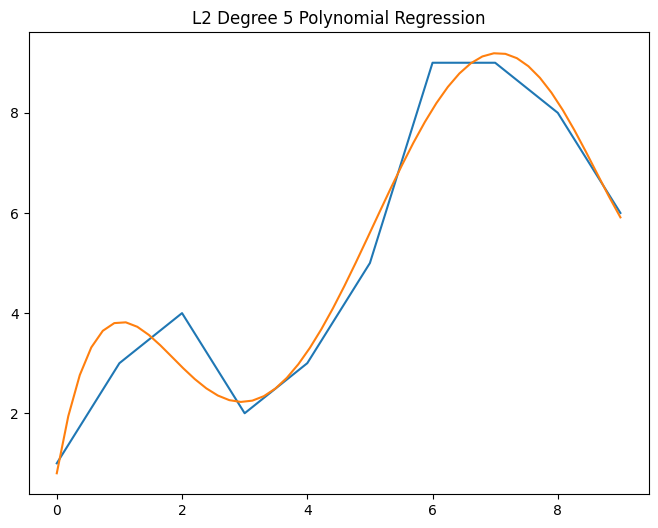

In [76]:
'''
solves for x for a system Ax=b where A is in row-echelon form (e.g. upper triangular)
'''
def backsub(A, b):
  n = b.shape[0]
  x = np.zeros_like(b)
  x[n-1] = b[n-1]/A[n-1, n-1]
  C = np.zeros((n,n))
  for i in range(n-2, -1, -1):
    bb = 0
    for j in range (i+1, n):
      bb += A[i, j]*x[j]

    C[i, i] = b[i] - bb
    x[i] = C[i, i]/A[i, i]
  return x

# returns parameters beta
def linear_regression(x, y):
  '''
  x - has shape (n, d) where n is number of data points and d is number of independent variables
  y - has shape (n)
  '''
  n, d = x.shape
  y = np.transpose(y)
  A = np.ones((n, d+1))
  A[:,1:] = x

  Q, R = np.linalg.qr(A)
  QTb = np.transpose(Q).dot(y)
  return backsub(R, QTb)

# Degree of polynomial fit
deg = 5
xf = np.array([x1**i for i in range(1,deg+1)]).T
f = linear_regression(xf, y1)

def poly(f, x):
  deg = len(f)
  x = np.array([x**i for i in range(deg)]).T
  return np.sum(x * f, axis=1)

xg = np.linspace(np.min(x1), np.max(x1), num=50)
yg = poly(f, xg)

plt.figure(figsize=(8,6))
plt.plot(x1, y1)
plt.plot(xg, yg)
plt.title(f'L2 Degree {deg} Polynomial Regression');